<a href="https://colab.research.google.com/github/flohmannjr/TCC530/blob/main/TCC530_Modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TCC530 - Modelos

## Importações de bibliotecas

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import random

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Embedding, TextVectorization
from tensorflow.keras.layers import Bidirectional, Concatenate, Conv1D, Dense
from tensorflow.keras.layers import Dropout, GlobalMaxPool1D, GRU, Input, LSTM

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

## Configurações

In [2]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100

sns.set_style("darkgrid")

### Constantes

In [3]:
SEMENTE = 2008193

LIMITE_DICIONARIO = 80000

MAXIMO_MODELOS = 20

ENTRADA_FORMATO = (1,)
ENTRADA_TIPO = tf.string

ATIVACAO_CNN = 'relu'
ATIVACAO_RNN = 'tanh'
ATIVACAO_SAIDA = 'sigmoid'

ESPACO_SAIDA = 50
NUCLEO_TAMANHO = 64
PREENCHIMENTO = 'same'

ABANDONOS = 0.1

PERDA = 'binary_crossentropy'
APRENDIZADO = 0.001
METRICAS = ['accuracy']

ITERACOES = 5

## Dados

Fake.Br Corpus https://github.com/roneysco/Fake.br-Corpus

In [4]:
dados = pd.read_csv('https://raw.githubusercontent.com/roneysco/Fake.br-Corpus/master/preprocessed/pre-processed.csv',
                    index_col=['index'])

In [5]:
dados['label'].replace({'fake': 0, 'true': 1}, inplace=True)

In [6]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7200 entries, 0 to 7199
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   label              7200 non-null   int64 
 1   preprocessed_news  7200 non-null   object
dtypes: int64(1), object(1)
memory usage: 168.8+ KB


In [7]:
dados

,label,preprocessed_news
index,,
0,0,katia abreu diz vai colocar expulsao moldura n...
1,0,ray peita bolsonaro conservador fake entrevist...
2,0,reinaldo azevedo desmascarado policia federal ...
3,0,relatorio assustador bndes mostra dinheiro pub...
4,0,radialista americano fala sobre pt vendem ilus...
...,...,...
7195,1,jornal britanico acao contra lula lava jato se...
7196,1,temer diz acionou pf cade investigar aumentos ...
7197,1,obstaculos politicos temer especialistas ouvid...


In [8]:
dados['label'].value_counts()

0    3600
1    3600
Name: label, dtype: int64

In [9]:
X = dados['preprocessed_news']
y = dados['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEMENTE)

In [10]:
# X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [11]:
# X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype

### Converter texto em números

In [12]:
# media_palavras_por_texto = round(sum([len(texto.split()) for texto in X_train]) / len(X_train))
maximo_palavras_por_texto = max([len(texto.split()) for texto in X_train])

# tamanho_texto = media_palavras_por_texto
tamanho_texto = maximo_palavras_por_texto

#### Vetorização (Vectorization)

In [13]:
vetorizador = TextVectorization(max_tokens=LIMITE_DICIONARIO,               # (Default: None) Máximo de tokens (palavras) no dicionário.
                                standardize='lower_and_strip_punctuation',  # (Default) Texto em caixa baixa e retira caracteres especiais.
                                split='whitespace',                         # (Default) Separador de tokens.
                                ngrams=None,                                # (Default) Tokens por grupo. (None = não agrupar tokens.)
                                output_mode='int',                          # (Default) Como mapear tokens para números.
                                output_sequence_length=tamanho_texto)       # (Default: None) Tamanho do texto, completado ou truncado, se necessário. (Válido apenas para 'int'.)

In [14]:
vetorizador.adapt(X_train)

In [15]:
# texto = random.choice(X_train)
# print(texto)

# vetorizador([texto])

In [16]:
vocabulario = vetorizador.get_vocabulary()

In [17]:
# [UNK] = Desconhecido, fora do limite do dicionário.
len(vocabulario), vocabulario[:5], vocabulario[-5:]

(73258,
 ['', '[UNK]', 'nao', 'lula', 'ser'],
 ['aapesar', 'aachen', 'aace', 'aabertura', 'aabb'])

#### Incorporação (Embedding)

In [18]:
incorporador = Embedding(input_dim=LIMITE_DICIONARIO,  # Tamanho do vocabulário de entrada.
                         output_dim=128,               # Dimensão do vetor de saída. (Geralmente um múltiplo de 8.)
                         input_length=tamanho_texto)   # Tamanho do texto de entrada.

In [19]:
# texto = random.choice(X_train)
# print(texto)

# incorporador(vetorizador([texto]))

## Funções

In [20]:
def grafico_historico_por_iteracao(historico):

    for chave in historico.history.keys():
        sns.lineplot(data=historico.history[chave], label=chave)

    plt.title('Histórico por iteração')
    plt.xlabel('Iteração')
    plt.ylabel('')

    plt.legend(frameon=True, facecolor='white')
    plt.show()

def avaliar_modelo(validacao, previsao, rotulos=None, cmap='summer_r'):
    print(classification_report(validacao, previsao, target_names=rotulos))

    ConfusionMatrixDisplay.from_predictions(validacao, previsao, display_labels=rotulos, xticks_rotation='vertical', cmap=cmap)
    plt.grid(False)

    relatorio = classification_report(validacao, previsao, target_names=rotulos, output_dict=True)

    return {'acuracia': relatorio['accuracy'],
            'precisao': relatorio['weighted avg']['precision'],
            'revocacao': relatorio['weighted avg']['recall'],
            'pontuacao-f1': relatorio['weighted avg']['f1-score']}

def dados_modelo(indice):
    avaliacoes[indice] = modelos[indice].evaluate(X_test, y_test)
    probabilidades[indice] = modelos[indice].predict(X_test)
    previsoes[indice] = tf.squeeze(tf.round(probabilidades[indice]))
    relatorios[indice] = avaliar_modelo(y_test, previsoes[indice])

## Modelos

In [21]:
modelos = [None] * MAXIMO_MODELOS

avaliacoes     = [None] * MAXIMO_MODELOS
probabilidades = [None] * MAXIMO_MODELOS
previsoes      = [None] * MAXIMO_MODELOS
relatorios     = [None] * MAXIMO_MODELOS

historicos = [None] * MAXIMO_MODELOS

modelo_numero = 0

### Modelo 0: Naive Bayes com codificador TF-IDF (baseline)

In [22]:
modelo_nome = f'modelo_{modelo_numero}_naive_bayes'

modelos[modelo_numero] = Pipeline([('tdidf', TfidfVectorizer()),
                                   ('clf', MultinomialNB())]) # clf = classifier

modelos[modelo_numero].fit(X_train, y_train)

Pipeline(steps=[('tdidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [23]:
previsoes[modelo_numero] = modelos[modelo_numero].predict(X_test)

              precision    recall  f1-score   support

           0       0.99      0.22      0.36       741
           1       0.55      1.00      0.71       699

    accuracy                           0.60      1440
   macro avg       0.77      0.61      0.53      1440
weighted avg       0.77      0.60      0.53      1440



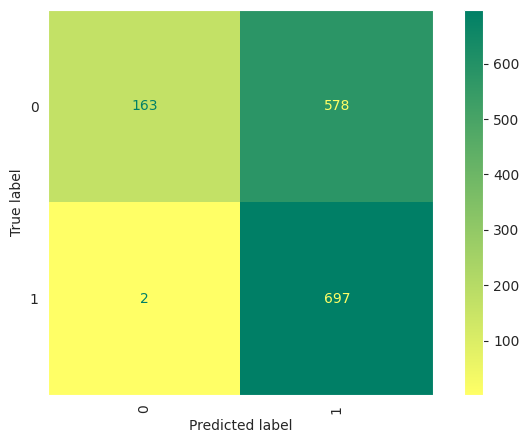

In [24]:
relatorios[modelo_numero] = avaliar_modelo(y_test, previsoes[modelo_numero])

In [25]:
relatorios[modelo_numero]

{'acuracia': 0.5972222222222222,
 'precisao': 0.7737070707070706,
 'revocacao': 0.5972222222222222,
 'pontuacao-f1': 0.5279508332382786}

### Camadas iniciais padronizadas

In [26]:
%%time

entradas = Input(shape=ENTRADA_FORMATO, dtype=ENTRADA_TIPO, name='camada_entrada')

camadas_iniciais = vetorizador(entradas)
camadas_iniciais = incorporador(camadas_iniciais)

CPU times: user 365 ms, sys: 4.18 ms, total: 369 ms
Wall time: 573 ms


### Modelo 1: Denso

In [27]:
%%time

modelo_numero += 1

modelo_nome = f'modelo_{modelo_numero}_denso'

camadas = GlobalMaxPool1D(name='agrupamento_maximo_global')(camadas_iniciais)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=Adam(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_TAMANHO,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_test, y_test),
                                                       verbose=1)

Epoch 1/5
90/90 [==============================] - 32s 299ms/step - loss: 0.6530 - accuracy: 0.6533 - val_loss: 0.6034 - val_accuracy: 0.7285
Epoch 2/5
90/90 [==============================] - 24s 262ms/step - loss: 0.5104 - accuracy: 0.8938 - val_loss: 0.4340 - val_accuracy: 0.9347
Epoch 3/5
90/90 [==============================] - 24s 269ms/step - loss: 0.3274 - accuracy: 0.9649 - val_loss: 0.2839 - val_accuracy: 0.9556
Epoch 4/5
90/90 [==============================] - 24s 265ms/step - loss: 0.2044 - accuracy: 0.9745 - val_loss: 0.2059 - val_accuracy: 0.9556
Epoch 5/5
90/90 [==============================] - 22s 243ms/step - loss: 0.1410 - accuracy: 0.9781 - val_loss: 0.1673 - val_accuracy: 0.9576
CPU times: user 1min 27s, sys: 1.98 s, total: 1min 29s
Wall time: 2min 5s


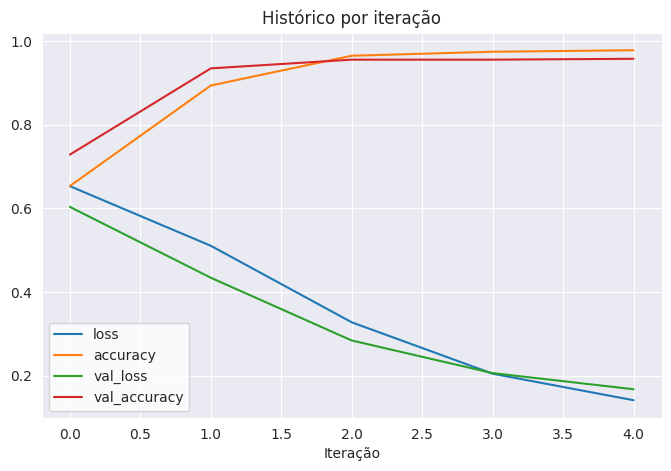

In [28]:
grafico_historico_por_iteracao(historicos[modelo_numero])

45/45 [==============================] - 0s 8ms/step
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       741
           1       0.96      0.95      0.96       699

    accuracy                           0.96      1440
   macro avg       0.96      0.96      0.96      1440
weighted avg       0.96      0.96      0.96      1440



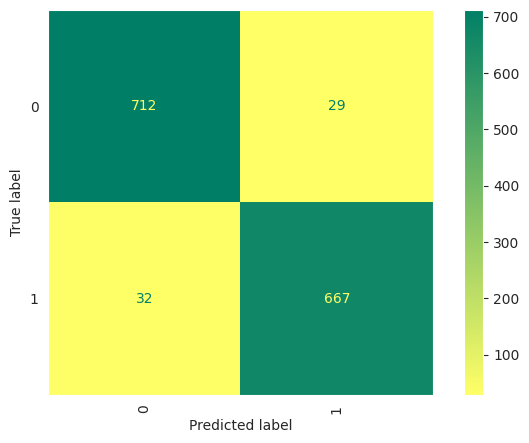

In [29]:
dados_modelo(modelo_numero)

In [30]:
relatorios[modelo_numero]

{'acuracia': 0.9576388888888889,
 'precisao': 0.9576416890681003,
 'revocacao': 0.9576388888888889,
 'pontuacao-f1': 0.9576361283081715}

### Modelo 2: LSTM

In [31]:
%%time

modelo_numero += 1

modelo_nome = f'modelo_{modelo_numero}_lstm'

# camadas = LSTM(units=ESPACO_SAIDA, activation=ATIVACAO_RNN, return_sequences=True)(camadas_iniciais) # Para empilhar camadas recorrentes é necessário return_sequences=True
# camadas = LSTM(units=ESPACO_SAIDA, activation=ATIVACAO_RNN)(camadas)
camadas = LSTM(units=ESPACO_SAIDA, activation=ATIVACAO_RNN)(camadas_iniciais)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=Adam(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_TAMANHO,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_test, y_test),
                                                       verbose=1)

Epoch 1/5
90/90 [==============================] - 36s 364ms/step - loss: 0.6944 - accuracy: 0.4965 - val_loss: 0.6927 - val_accuracy: 0.5146
Epoch 2/5
90/90 [==============================] - 29s 327ms/step - loss: 0.6937 - accuracy: 0.5017 - val_loss: 0.6950 - val_accuracy: 0.4854
Epoch 3/5
90/90 [==============================] - 32s 361ms/step - loss: 0.6927 - accuracy: 0.5134 - val_loss: 0.6941 - val_accuracy: 0.5146
Epoch 4/5
90/90 [==============================] - 30s 335ms/step - loss: 0.6939 - accuracy: 0.4984 - val_loss: 0.6930 - val_accuracy: 0.5146
Epoch 5/5
90/90 [==============================] - 28s 310ms/step - loss: 0.6934 - accuracy: 0.4953 - val_loss: 0.6936 - val_accuracy: 0.4854
CPU times: user 2min 11s, sys: 2.16 s, total: 2min 13s
Wall time: 3min 24s


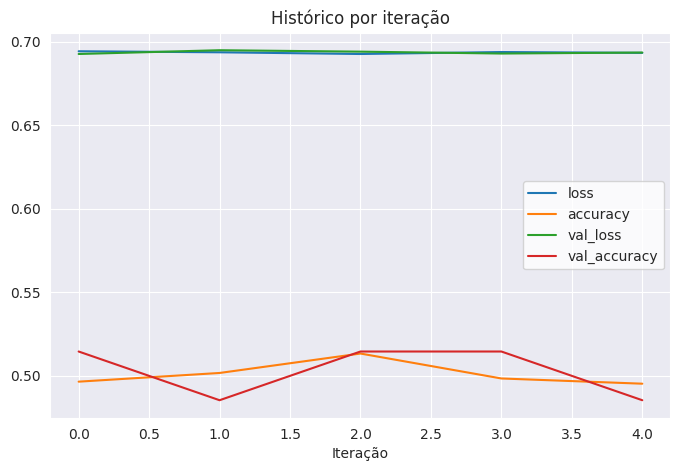

In [32]:
grafico_historico_por_iteracao(historicos[modelo_numero])

45/45 [==============================] - 3s 50ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       741
           1       0.49      1.00      0.65       699

    accuracy                           0.49      1440
   macro avg       0.24      0.50      0.33      1440
weighted avg       0.24      0.49      0.32      1440



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

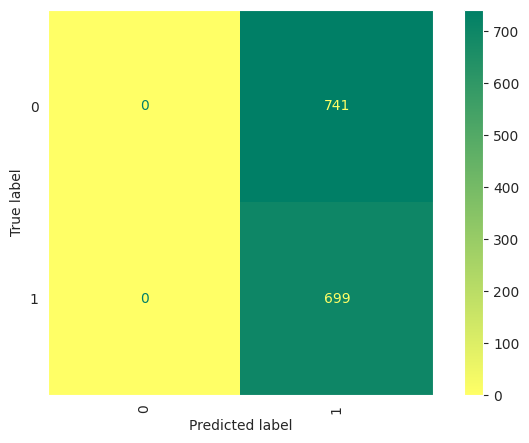

In [33]:
dados_modelo(modelo_numero)

In [34]:
relatorios[modelo_numero]

{'acuracia': 0.48541666666666666,
 'precisao': 0.23562934027777777,
 'revocacao': 0.48541666666666666,
 'pontuacao-f1': 0.31725689574567556}

### Modelo 3: GRU

In [35]:
%%time

modelo_numero += 1

modelo_nome = f'modelo_{modelo_numero}_gru'

# camadas = GRU(units=ESPACO_SAIDA, activation=ATIVACAO_RNN, return_sequences=True)(camadas_iniciais)
# camadas = GRU(units=ESPACO_SAIDA, activation=ATIVACAO_RNN)(camadas)
camadas = GRU(units=ESPACO_SAIDA, activation=ATIVACAO_RNN)(camadas_iniciais)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=Adam(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_TAMANHO,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_test, y_test),
                                                       verbose=1)

Epoch 1/5
90/90 [==============================] - 37s 380ms/step - loss: 0.6940 - accuracy: 0.4977 - val_loss: 0.6954 - val_accuracy: 0.4854
Epoch 2/5
90/90 [==============================] - 30s 339ms/step - loss: 0.6942 - accuracy: 0.5002 - val_loss: 0.6944 - val_accuracy: 0.4854
Epoch 3/5
90/90 [==============================] - 31s 341ms/step - loss: 0.6939 - accuracy: 0.5064 - val_loss: 0.6928 - val_accuracy: 0.5146
Epoch 4/5
90/90 [==============================] - 28s 316ms/step - loss: 0.6937 - accuracy: 0.5021 - val_loss: 0.6934 - val_accuracy: 0.4854
Epoch 5/5
90/90 [==============================] - 27s 304ms/step - loss: 0.6937 - accuracy: 0.4899 - val_loss: 0.6934 - val_accuracy: 0.4854
CPU times: user 2min 12s, sys: 1.57 s, total: 2min 14s
Wall time: 2min 34s


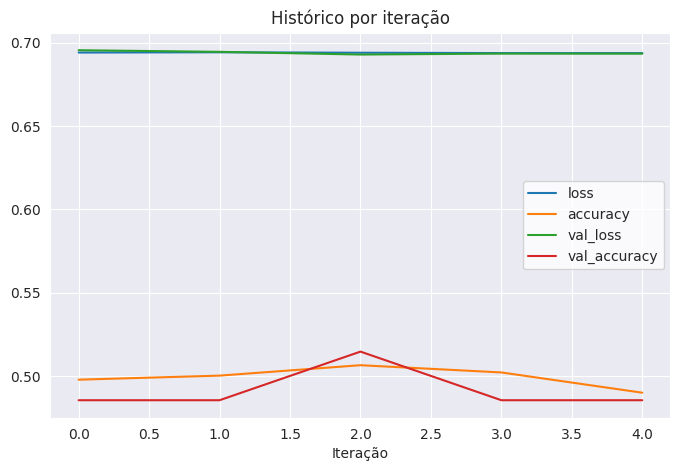

In [36]:
grafico_historico_por_iteracao(historicos[modelo_numero])

45/45 [==============================] - 3s 56ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       741
           1       0.49      1.00      0.65       699

    accuracy                           0.49      1440
   macro avg       0.24      0.50      0.33      1440
weighted avg       0.24      0.49      0.32      1440



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

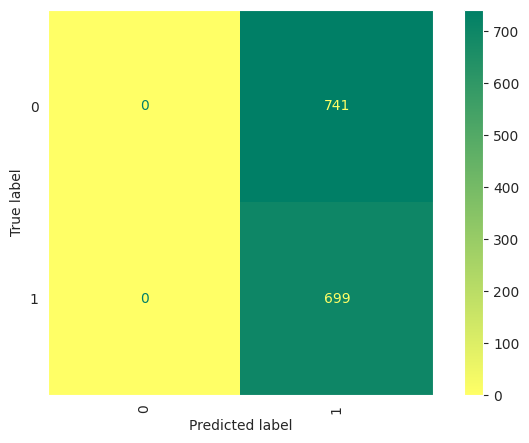

In [37]:
dados_modelo(modelo_numero)

In [38]:
relatorios[modelo_numero]

{'acuracia': 0.48541666666666666,
 'precisao': 0.23562934027777777,
 'revocacao': 0.48541666666666666,
 'pontuacao-f1': 0.31725689574567556}

### Modelo 4: LSTM Bidirecional

In [39]:
%%time

modelo_numero += 1

modelo_nome = f'modelo_{modelo_numero}_lstm_bidirecional'

# camadas = Bidirectional(layer=LSTM(units=ESPACO_SAIDA, activation=ATIVACAO_RNN, return_sequences=True))(camadas_iniciais)
# camadas = Bidirectional(layer=LSTM(units=ESPACO_SAIDA, activation=ATIVACAO_RNN))(camadas)
camadas = Bidirectional(layer=LSTM(units=ESPACO_SAIDA, activation=ATIVACAO_RNN))(camadas_iniciais)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=Adam(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_TAMANHO,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_test, y_test),
                                                       verbose=1)

Epoch 1/5
90/90 [==============================] - 50s 497ms/step - loss: 0.4296 - accuracy: 0.8285 - val_loss: 0.2222 - val_accuracy: 0.9215
Epoch 2/5
90/90 [==============================] - 41s 449ms/step - loss: 0.1030 - accuracy: 0.9719 - val_loss: 0.1347 - val_accuracy: 0.9569
Epoch 3/5
90/90 [==============================] - 39s 429ms/step - loss: 0.0331 - accuracy: 0.9918 - val_loss: 0.1275 - val_accuracy: 0.9590
Epoch 4/5
90/90 [==============================] - 40s 445ms/step - loss: 0.0082 - accuracy: 0.9995 - val_loss: 0.1400 - val_accuracy: 0.9632
Epoch 5/5
90/90 [==============================] - 43s 481ms/step - loss: 0.0248 - accuracy: 0.9927 - val_loss: 0.1796 - val_accuracy: 0.9438
CPU times: user 3min 8s, sys: 4.85 s, total: 3min 13s
Wall time: 4min 26s


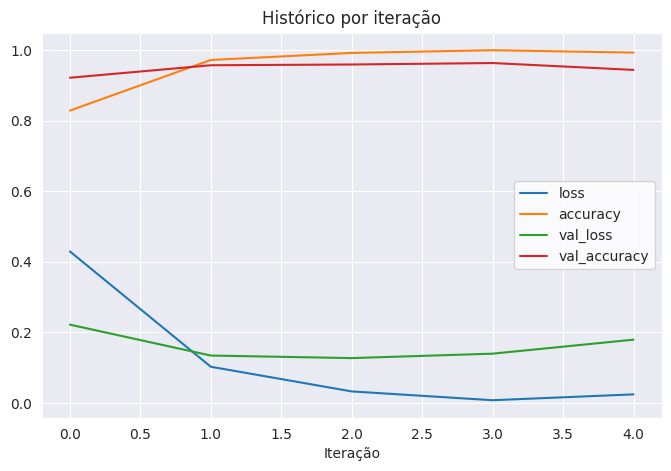

In [40]:
grafico_historico_por_iteracao(historicos[modelo_numero])

45/45 [==============================] - 5s 89ms/step
              precision    recall  f1-score   support

           0       0.98      0.91      0.94       741
           1       0.91      0.98      0.94       699

    accuracy                           0.94      1440
   macro avg       0.94      0.94      0.94      1440
weighted avg       0.95      0.94      0.94      1440



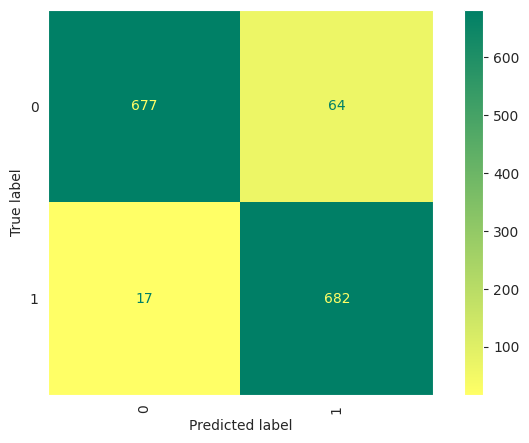

In [41]:
dados_modelo(modelo_numero)

In [42]:
relatorios[modelo_numero]

{'acuracia': 0.94375,
 'precisao': 0.9457506074665266,
 'revocacao': 0.94375,
 'pontuacao-f1': 0.9437436251401566}

### Modelo 5: GRU Bidirecional

In [43]:
%%time

modelo_numero += 1

modelo_nome = f'modelo_{modelo_numero}_gru_bidirecional'

# camadas = Bidirectional(layer=GRU(units=ESPACO_SAIDA, activation=ATIVACAO_RNN, return_sequences=True))(camadas_iniciais)
# camadas = Bidirectional(layer=GRU(units=ESPACO_SAIDA, activation=ATIVACAO_RNN))(camadas)
camadas = Bidirectional(layer=GRU(units=ESPACO_SAIDA, activation=ATIVACAO_RNN))(camadas_iniciais)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=Adam(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_TAMANHO,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_test, y_test),
                                                       verbose=1)

Epoch 1/5
90/90 [==============================] - 46s 457ms/step - loss: 0.2815 - accuracy: 0.8990 - val_loss: 0.2492 - val_accuracy: 0.9250
Epoch 2/5
90/90 [==============================] - 38s 420ms/step - loss: 0.0348 - accuracy: 0.9918 - val_loss: 0.2901 - val_accuracy: 0.9319
Epoch 3/5
90/90 [==============================] - 38s 426ms/step - loss: 0.0140 - accuracy: 0.9970 - val_loss: 0.2730 - val_accuracy: 0.9250
Epoch 4/5
90/90 [==============================] - 38s 418ms/step - loss: 0.0066 - accuracy: 0.9988 - val_loss: 0.3196 - val_accuracy: 0.9271
Epoch 5/5
90/90 [==============================] - 38s 419ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.3516 - val_accuracy: 0.9306
CPU times: user 3min 3s, sys: 3 s, total: 3min 6s
Wall time: 3min 26s


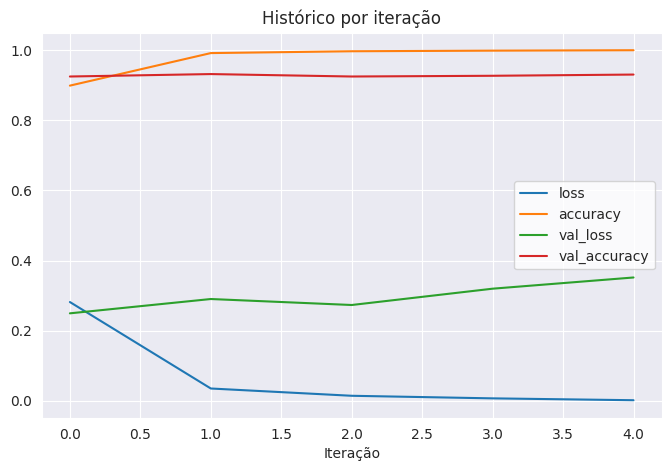

In [44]:
grafico_historico_por_iteracao(historicos[modelo_numero])

45/45 [==============================] - 5s 92ms/step
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       741
           1       0.92      0.94      0.93       699

    accuracy                           0.93      1440
   macro avg       0.93      0.93      0.93      1440
weighted avg       0.93      0.93      0.93      1440



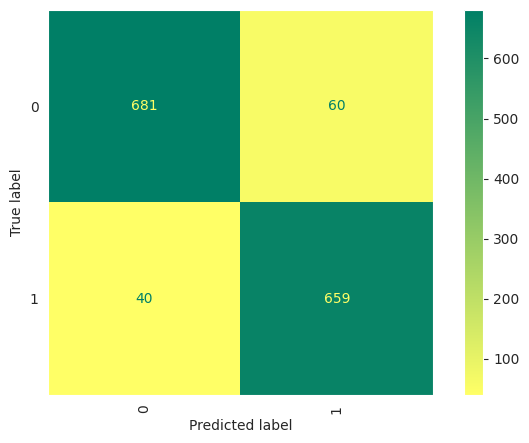

In [45]:
dados_modelo(modelo_numero)

In [46]:
relatorios[modelo_numero]

{'acuracia': 0.9305555555555556,
 'precisao': 0.930944037957892,
 'revocacao': 0.9305555555555556,
 'pontuacao-f1': 0.9305702945067553}

### Modelo 6: CNN

In [47]:
%%time

modelo_numero += 1

modelo_nome = f'modelo_{modelo_numero}_cnn'

camadas = Conv1D(filters=ESPACO_SAIDA,
                 kernel_size=NUCLEO_TAMANHO,
                 activation=ATIVACAO_CNN,
                 padding=PREENCHIMENTO,
                 name='camada_convulacional')(camadas_iniciais)

camadas = GlobalMaxPool1D(name='agrupamento_maximo_global')(camadas)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=Adam(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_TAMANHO,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_test, y_test),
                                                       verbose=1)

Epoch 1/5
90/90 [==============================] - 29s 269ms/step - loss: 0.1234 - accuracy: 0.9658 - val_loss: 0.1808 - val_accuracy: 0.9319
Epoch 2/5
90/90 [==============================] - 21s 237ms/step - loss: 0.0078 - accuracy: 0.9990 - val_loss: 0.2016 - val_accuracy: 0.9319
Epoch 3/5
90/90 [==============================] - 22s 240ms/step - loss: 0.0023 - accuracy: 0.9998 - val_loss: 0.2008 - val_accuracy: 0.9312
Epoch 4/5
90/90 [==============================] - 21s 230ms/step - loss: 0.0015 - accuracy: 0.9998 - val_loss: 0.2119 - val_accuracy: 0.9292
Epoch 5/5
90/90 [==============================] - 22s 242ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 0.2293 - val_accuracy: 0.9312
CPU times: user 1min 33s, sys: 2.06 s, total: 1min 35s
Wall time: 2min 22s


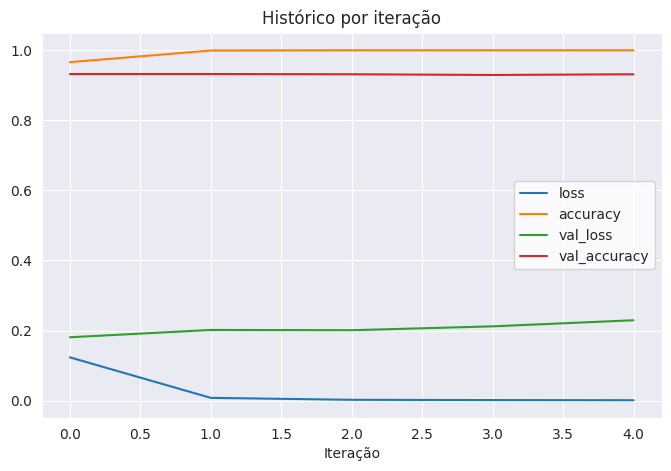

In [48]:
grafico_historico_por_iteracao(historicos[modelo_numero])

45/45 [==============================] - 1s 15ms/step
              precision    recall  f1-score   support

           0       0.97      0.89      0.93       741
           1       0.89      0.98      0.93       699

    accuracy                           0.93      1440
   macro avg       0.93      0.93      0.93      1440
weighted avg       0.93      0.93      0.93      1440



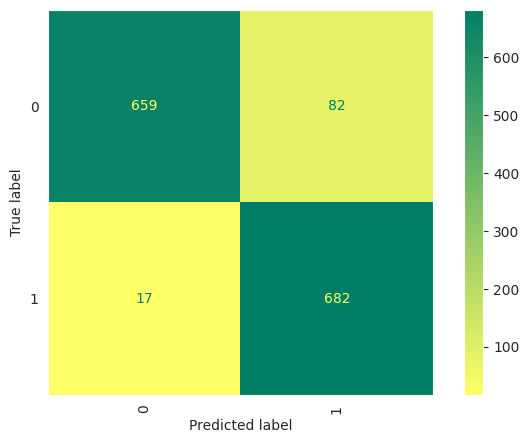

In [49]:
dados_modelo(modelo_numero)

In [50]:
relatorios[modelo_numero]

{'acuracia': 0.93125,
 'precisao': 0.934959600281917,
 'revocacao': 0.93125,
 'pontuacao-f1': 0.9312004207767125}

### Modelo 7: TFHub Universal Sentence Encoder

Universal Sentence Encoder: https://tfhub.dev/google/universal-sentence-encoder/4

In [51]:
%%time

modelo_numero += 1

modelo_nome = f'modelo_{modelo_numero}_tfhub_use'

modelos[modelo_numero] = Sequential(name=modelo_nome)

modelos[modelo_numero].add(hub.KerasLayer(handle='https://tfhub.dev/google/universal-sentence-encoder/4',
                                          trainable=False,
                                          input_shape=[], # USE aceita textos de tamanho variável.
                                          dtype=ENTRADA_TIPO,
                                          name='camada_use'))

modelos[modelo_numero].add(Dense(ESPACO_SAIDA*2, activation=ATIVACAO_CNN, name='camada_relu'))
modelos[modelo_numero].add(Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida'))

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=Adam(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_TAMANHO,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_test, y_test),
                                                       verbose=1)

Epoch 1/5
90/90 [==============================] - 20s 171ms/step - loss: 0.3098 - accuracy: 0.9187 - val_loss: 0.1751 - val_accuracy: 0.9312
Epoch 2/5
90/90 [==============================] - 15s 164ms/step - loss: 0.1720 - accuracy: 0.9408 - val_loss: 0.1630 - val_accuracy: 0.9375
Epoch 3/5
90/90 [==============================] - 15s 168ms/step - loss: 0.1638 - accuracy: 0.9418 - val_loss: 0.1581 - val_accuracy: 0.9361
Epoch 4/5
90/90 [==============================] - 17s 191ms/step - loss: 0.1578 - accuracy: 0.9451 - val_loss: 0.1573 - val_accuracy: 0.9375
Epoch 5/5
90/90 [==============================] - 15s 168ms/step - loss: 0.1542 - accuracy: 0.9469 - val_loss: 0.1512 - val_accuracy: 0.9431
CPU times: user 1min 32s, sys: 2.81 s, total: 1min 35s
Wall time: 1min 36s


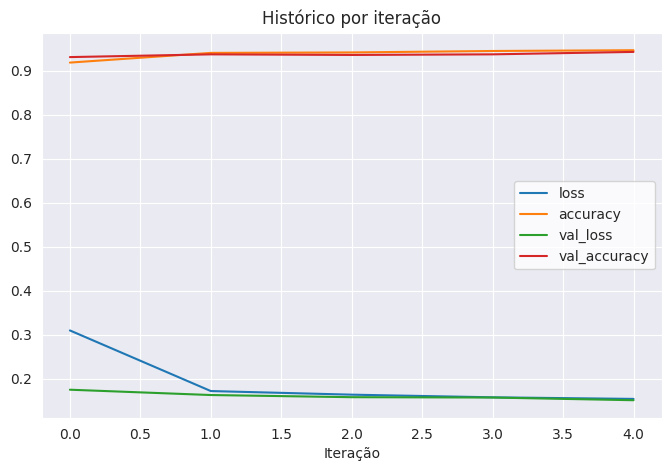

In [52]:
grafico_historico_por_iteracao(historicos[modelo_numero])

45/45 [==============================] - 3s 58ms/step
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       741
           1       0.96      0.93      0.94       699

    accuracy                           0.94      1440
   macro avg       0.94      0.94      0.94      1440
weighted avg       0.94      0.94      0.94      1440



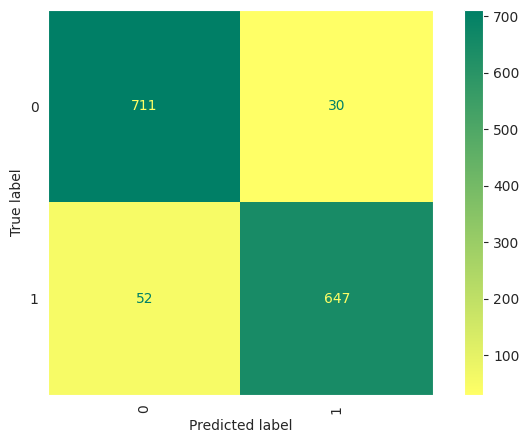

In [53]:
dados_modelo(modelo_numero)

In [54]:
relatorios[modelo_numero]

{'acuracia': 0.9430555555555555,
 'precisao': 0.9434197607464381,
 'revocacao': 0.9430555555555555,
 'pontuacao-f1': 0.9430168130463468}

### Modelo 8: DCNN

In [55]:
%%time

modelo_numero += 1

modelo_nome = f'modelo_{modelo_numero}_dcnn'

# Bigram

bigram = Conv1D(filters=ESPACO_SAIDA,
                kernel_size=2,
                activation=ATIVACAO_CNN,
                padding=PREENCHIMENTO,
                name='camada_bigram')(camadas_iniciais)

bigram = GlobalMaxPool1D(name='agrupamento_maximo_bigram')(bigram)

# Trigram

trigram = Conv1D(filters=ESPACO_SAIDA,
                 kernel_size=3,
                 activation=ATIVACAO_CNN,
                 padding=PREENCHIMENTO,
                 name='camada_trigram')(camadas_iniciais)

trigram = GlobalMaxPool1D(name='agrupamento_maximo_trigram')(trigram)

# Fourgram

fourgram = Conv1D(filters=ESPACO_SAIDA,
                  kernel_size=4,
                  activation=ATIVACAO_CNN,
                  padding=PREENCHIMENTO,
                  name='camada_fourgram')(camadas_iniciais)

fourgram = GlobalMaxPool1D(name='agrupamento_maximo_fourgram')(fourgram)

# Concatenação dos ngrams

# camadas = tf.concat([bigram, trigram, fourgram], axis=-1)
camadas = Concatenate(name="camada_concatenacao")([bigram, trigram, fourgram])

# Camada densa

camadas = Dense(units=512, activation=ATIVACAO_CNN, name='camada_densa')(camadas)

# Camada de abandono

camadas = Dropout(rate=ABANDONOS, name='camada_abandono')(camadas)

# Camada de saída

saidas = Dense(units=1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=Adam(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_TAMANHO,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_test, y_test),
                                                       verbose=1)

Epoch 1/5
90/90 [==============================] - 27s 263ms/step - loss: 0.2211 - accuracy: 0.9219 - val_loss: 0.1417 - val_accuracy: 0.9486
Epoch 2/5
90/90 [==============================] - 23s 256ms/step - loss: 0.0320 - accuracy: 0.9920 - val_loss: 0.1420 - val_accuracy: 0.9479
Epoch 3/5
90/90 [==============================] - 22s 250ms/step - loss: 0.0037 - accuracy: 0.9998 - val_loss: 0.1496 - val_accuracy: 0.9500
Epoch 4/5
90/90 [==============================] - 21s 231ms/step - loss: 9.2856e-04 - accuracy: 1.0000 - val_loss: 0.1568 - val_accuracy: 0.9479
Epoch 5/5
90/90 [==============================] - 20s 226ms/step - loss: 5.1409e-04 - accuracy: 1.0000 - val_loss: 0.1635 - val_accuracy: 0.9465
CPU times: user 1min 30s, sys: 1.78 s, total: 1min 32s
Wall time: 2min 23s


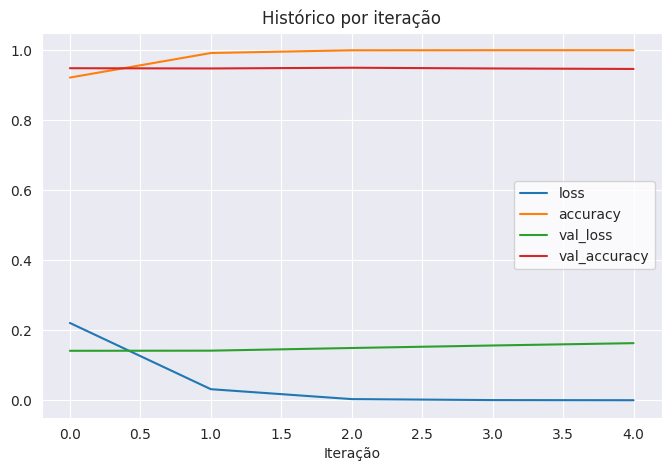

In [56]:
grafico_historico_por_iteracao(historicos[modelo_numero])

45/45 [==============================] - 1s 17ms/step
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       741
           1       0.92      0.97      0.95       699

    accuracy                           0.95      1440
   macro avg       0.95      0.95      0.95      1440
weighted avg       0.95      0.95      0.95      1440



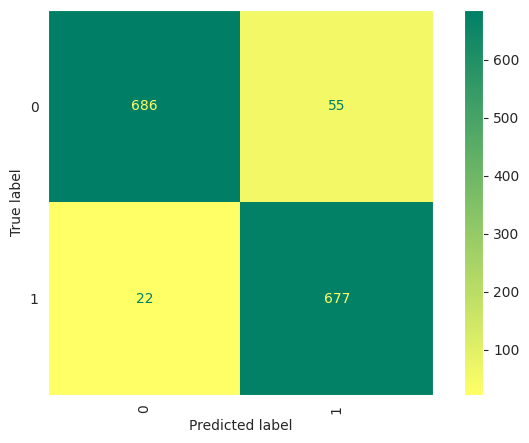

In [57]:
dados_modelo(modelo_numero)

In [58]:
relatorios[modelo_numero]

{'acuracia': 0.9465277777777777,
 'precisao': 0.9475375586582693,
 'revocacao': 0.9465277777777777,
 'pontuacao-f1': 0.9465354368587893}

## Comparar modelos

In [59]:
comparacao = pd.DataFrame([r for r in relatorios if r is not None])
comparacao = comparacao.reset_index().melt(id_vars='index').rename(columns=str.title)

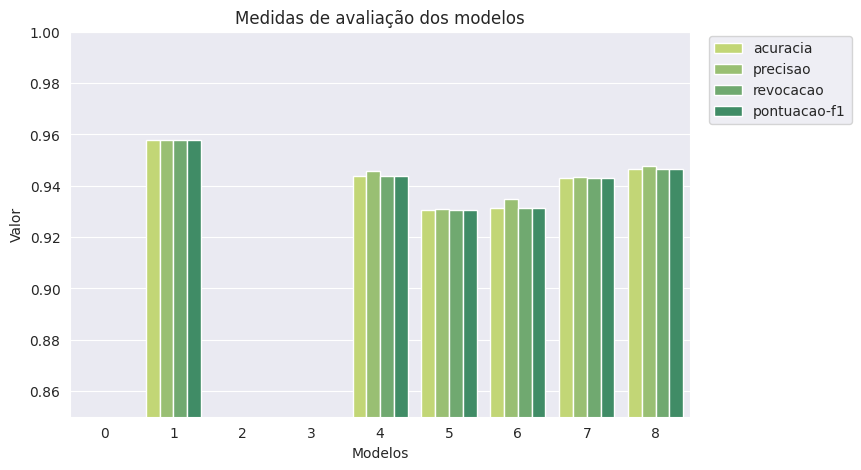

In [60]:
sns.barplot(data=comparacao, x='Index', y='Value', hue='Variable', palette='summer_r')

plt.ylim(0.85, 1.0)

plt.title('Medidas de avaliação dos modelos')
plt.xlabel('Modelos')
plt.ylabel('Valor')

plt.legend(loc=(1.03, 0.76));